In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer

class JobDataset:
    def __init__(self, file_path='./JobLevelData.xlsx', model_name='roberta-base', tokenizer_length=128, batch_size=32, add_extra_data=True, preprocess_nans=True):
        self.file_path = file_path
        self.model_name = model_name
        self.tokenizer_length = tokenizer_length
        self.batch_size = batch_size
        self.add_extra_data = add_extra_data
        self.preprocess_nans = preprocess_nans
        self.tokenizer = RobertaTokenizer.from_pretrained(model_name)
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.labels_num = None
        self.label_mapping = {
            0: 'Individual Contributor/Staff',
            1: 'Director',
            2: 'Vice President',
            3: 'Manager',
            4: 'Chief Officer',
            5: 'Owner'
            # 0: 'Vice President',
            # 1: 'Manager',
            # 2: 'Individual Contributor/Staff',
            # 3: 'Chief Officer',
            # 4: 'Owner',
            # 5: 'Director'
        }

    def load_data(self):
        self.df = pd.read_excel(self.file_path)
        if self.preprocess_nans:
            self._handle_nans()
        if self.add_extra_data:
            self._add_extra_data()
        self._preprocess_data()
        self._one_hot_encode()


    def _handle_nans(self):
        self.df.loc[29, 'Column 1'] = 'Chief Officer'                        # CINO
        self.df.loc[829, 'Column 1'] = 'Individual Contributor/Staff'        # Release of Information Tech II
        self.df.loc[1406, 'Column 1'] = 'Manager'                            # Global People Systems, Processes and Information Manager
        self.df.loc[1713, 'Column 1'] = 'Individual Contributor/Staff'       # Supplier Quality Enginee
        self.df.loc[1785, 'Column 1'] = 'Manager'                            # RC Environmental and Cyber Specialized Subscription Manager
        self.df.loc[2182, 'Column 1'] = 'Director'                           # Senior IndependeDirector and Chair of the Customer and Communities Network
        self.df.loc[2182, 'Title'] = 'Senior Independent Director and Chair of the Customer and Communities Network'        # Senior IndependeDirector and Chair of the Customer and Communities Network

    def _add_extra_data(self):
        new_rows = [
            {'Title': 'CEO & CO-OWNER', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'CEO & Founder', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'CEO & CO-founder', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'Founder, CTO', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'Founder', 'Column 1': 'Owner'},
            {'Title': 'Founder & CEO', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'Founder and visionar', 'Column 1': 'Owner'},
            {'Title': 'CEO/Founder', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'CEO & founder', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
            {'Title': 'Chief Business Development Officer & Co-Founder', 'Column 1': 'Owner', 'Column 2': 'Chief Officer'},
        ]
        self.df = pd.concat([self.df, pd.DataFrame(new_rows)], ignore_index=True)

    def _preprocess_data(self):
        self.df['Title'] = self.df['Title'].apply(self.preprocess_title)


    def preprocess_title(self, title):
        # Lowercase and remove special characters
        title = title.lower()
        title = re.sub(r'[^\w\s]', ' ', title)
        title = re.sub(r'\s{2,}', ' ', title)

        # Remove stop words
        nltk.download('stopwords', quiet=True)
        stop_words = set(stopwords.words('english'))
        stop_words.remove('it')
        title = ' '.join([word for word in title.split() if word not in stop_words])
        
        # Normalize job titles
        job_title_dict = {
            # misspelings
            'vise': 'vice',
            'senoir': 'senior',
            'maneger': 'manager',
            'assistent': 'assistant',
            'supervisr': 'supervisor',
            'analist': 'analyst',
            'enginere': 'engineer',
            'developr': 'developer',
            'programer': 'programmer',
            'acountant': 'accountant',
            'lawer': 'lawyer',
            'docter': 'doctor',
            'analista': 'analyst',
            # short forms
            'dev': 'developer',
            'dev.': 'developer',
            'eng': 'engineer',
            'eng.': 'engineer',
            'engr': 'engineer',
            'engr.': 'engineer',
            # title prefixes 
            'reg': 'regional',
            'reg.': 'regional',
            'assoc': 'associate',
            'assoc.': 'associate',
            'asst': 'assistant',
            'asst.': 'assistant',
            'exec': 'executive',
            'exec.': 'executive',
            'deputy': 'deputy',
            'deputy.': 'deputy',
            'mng': 'managing',
            'mng.': 'managing',
            # expertise level
            'sr': 'senior',
            'sr.': 'senior',
            'snr': 'senior',
            'snr.': 'senior',
            'sen': 'senior',
            'sen.': 'senior',
            'jr': 'junior',
            'jr.': 'junior',
            'jnr': 'junior',
            'jnr.': 'junior',
            'jun': 'junior',
            'jun.': 'junior',
            'mid': 'middle',
            'mid.': 'middle',
            'mdl': 'middle',
            'mdl.': 'middle',
            # vice president
            'vp': 'vice president',
            'svp': 'senior vice president',
            'evp': 'executive vice president',
            'avp': 'assistant vice president',
            'sevp': 'senior executive vice president',
            'gvp': 'group vice president',
            'dvp': 'divisional vice president',
            'rvp': 'regional vice president',
            'cvp': 'corporate vice president',
            'davp': 'deputy assistant vice president',
            'savp': 'senior assistant vice president',
            'mvp': 'managing vice president',
            'arvp': 'associate regional vice president',
            # c level officers
            'ceo': 'chief executive officer',
            'cfo': 'chief financial officer',
            'coo': 'chief operating officer',
            'cto': 'chief technology officer',
            'cio': 'chief information officer',
            'chro': 'chief human resources officer',
            'cdo': 'chief data officer',
            'cmo': 'chief marketing officer',
            'cso': 'chief sales officer',
            'cco': 'chief communications officer',
            'cro': 'chief relationship officer',
            # directors
            'dir': 'director',
            'dir.': 'director',
            # managers
            'mgr': 'manager',
            'mgr.': 'manager',
            'mng': 'manager',
            'mng.': 'manager',
            'mngr': 'manager',
            'mngr.': 'manager',
        }
        
        title = ' '.join([job_title_dict.get(word, word) for word in title.split()])
        return title

    def _one_hot_encode(self):
        columns_to_encode = ['Column 1', 'Column 2', 'Column 3', 'Column 4']
        one_hot_encoded = pd.DataFrame()
        unique_values = set()
        for column in columns_to_encode:
            values = self.df[column].dropna().unique().tolist()
            unique_values.update(values)
        self.labels_num = len(unique_values)
        for i, value in enumerate(unique_values):
            one_hot_encoded[f'Label_{value}'] = self.df[columns_to_encode].eq(value).any(axis=1).astype(int)
            # self.label_mapping[i] = value  # Add this line to create the mapping
        # for i, value in self.label_mapping.items():
        #     one_hot_encoded[f'Label_{value}'] = self.df[columns_to_encode].eq(value).any(axis=1).astype(int)

        # Rearrange columns to match label_mapping order
        ordered_columns = [f'Label_{self.label_mapping[i]}' for i in range(len(self.label_mapping))]
        one_hot_encoded = one_hot_encoded[ordered_columns]
        self.df = pd.concat([self.df['Title'], one_hot_encoded], axis=1)

    def tokenize(self, text):
        input_ids = []
        attention_masks = []
        tokens = self.tokenizer.encode_plus(text, max_length=self.tokenizer_length,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')   
         
        input_ids.append(np.asarray(tokens["input_ids"]).reshape(self.tokenizer_length,))
        attention_masks.append(np.asarray(tokens["attention_mask"]).reshape(self.tokenizer_length,))

        return (np.asarray(input_ids), np.asarray(attention_masks))

    
    def get_train_validation_split(self, test_size=0.2, random_state=42):
        X = self.df['Title'].values
        y = self.df.drop('Title', axis=1).values
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Tokenize the text data
        X_train_tokenized = []
        X_valid_tokenized = []
        
        for text in X_train:
            X_train_tokenized.append(self.tokenize(text))

        for text in X_valid:
            X_valid_tokenized.append(self.tokenize(text))

        # Separate input_ids and attention_masks
        X_train_input_ids = np.array([item[0][0] for item in X_train_tokenized])
        X_train_attention_masks = np.array([item[1][0] for item in X_train_tokenized])
        X_valid_input_ids = np.array([item[0][0] for item in X_valid_tokenized])
        X_valid_attention_masks = np.array([item[1][0] for item in X_valid_tokenized])

        return (
            X_train_input_ids,
            X_train_attention_masks,
            X_valid_input_ids,
            X_valid_attention_masks,
            y_train.astype(np.float32),
            y_valid.astype(np.float32)
        )

    def predict_labels(self, prediction_array, threshold=0.5):
        predicted_labels = []
        for i, prob in enumerate(prediction_array):
            if prob >= threshold:
                predicted_labels.append(self.label_mapping[i])
        return predicted_labels


In [3]:
def create_model():
    transformer_model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

    input_ids = tf.keras.layers.Input(shape=(TOKENIZER_LENGTH,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(TOKENIZER_LENGTH,), dtype=tf.int32, name='attention_mask')

    embeddings = transformer_model(input_ids, attention_mask=attention_mask)[0]
    output = tf.keras.layers.Activation('sigmoid')(embeddings)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

In [4]:
def plot_training_history(history):
    # List of metrics to plot
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall', 'f1_score']
    
    # Create a figure with subplots
    fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    fig.suptitle('Model Training History')
    
    for i, metric in enumerate(metrics):
        # Plot training & validation metric values
        axs[i].plot(history.history[metric], label=f'Train {metric}')
        axs[i].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        
        axs[i].set_title(f'{metric.capitalize()} Over Epochs')
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()
        axs[i].grid(True)
    
    plt.tight_layout()
    plt.show()

In [5]:
dataset = JobDataset('/kaggle/input/organizationalroles/JobLevelData.xlsx')
dataset.load_data()
train_input_ids, train_attention_masks, valid_input_ids, valid_attention_masks,y_train,y_valid = dataset.get_train_validation_split(test_size=0.2, random_state=42)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
display(dataset.df.head())

,Title,Label_Individual Contributor/Staff,Label_Director,Label_Vice President,Label_Manager,Label_Chief Officer,Label_Owner
0,vice president director systems engineering,0,0,1,0,0,0
1,systems engineer systems architect,1,0,0,1,0,0
2,executive director global it infrastructure ch...,0,1,0,0,1,0
3,chief technology officer executive director te...,0,1,0,0,1,0
4,vice president chief information officer,0,0,1,0,0,0


In [7]:
MODEL_NAME = 'roberta-base'
NUM_LABELS = dataset.labels_num
EPOCH = 100
PATIENCE_CALLBACK = 25
LR_CALLBACK = 10
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
TOKENIZER_LENGTH = 128

In [8]:
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs available: {len(gpus)}")

Number of GPUs available: 1


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246502   ['input_ids[0][0]',           
 assification (TFRobertaFor  (loss=None, logits=(None,    46         'attention_mask[0][0]']      
 SequenceClassification)     6),                                                              

I0000 00:00:1727044010.554753     103 service.cc:145] XLA service 0x79b68c6962f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727044010.554807     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727044010.724278     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.8125 - auc: 0.7118 - precision: 0.4568 - recall: 0.2715 - f1_score: 0.1633
Epoch 1: val_f1_score improved from -inf to 0.25885, saving model to ./models/best_model.keras


/opt/conda/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)



Epoch 1: val_f1_score improved from -inf to 0.25885, saving model to ./weights/best_model_weights.h5
57/57 [==============================] - 129s 841ms/step - loss: 0.4922 - accuracy: 0.8125 - auc: 0.7118 - precision: 0.4568 - recall: 0.2715 - f1_score: 0.1633 - val_loss: 0.3398 - val_accuracy: 0.8907 - val_auc: 0.8760 - val_precision: 0.7561 - val_recall: 0.5764 - val_f1_score: 0.2588 - lr: 1.0000e-05
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9205 - auc: 0.9362 - precision: 0.8667 - recall: 0.6547 - f1_score: 0.4722
Epoch 2: val_f1_score improved from 0.25885 to 0.58393, saving model to ./models/best_model.keras

Epoch 2: val_f1_score improved from 0.25885 to 0.58393, saving model to ./weights/best_model_weights.h5
57/57 [==============================] - 36s 638ms/step - loss: 0.2797 - accuracy: 0.9205 - auc: 0.9362 - precision: 0.8667 - recall: 0.6547 - f1_score: 0.4722 - val_loss: 0.2002 - val_accuracy: 0.9556 - val_auc: 0.9668 - va

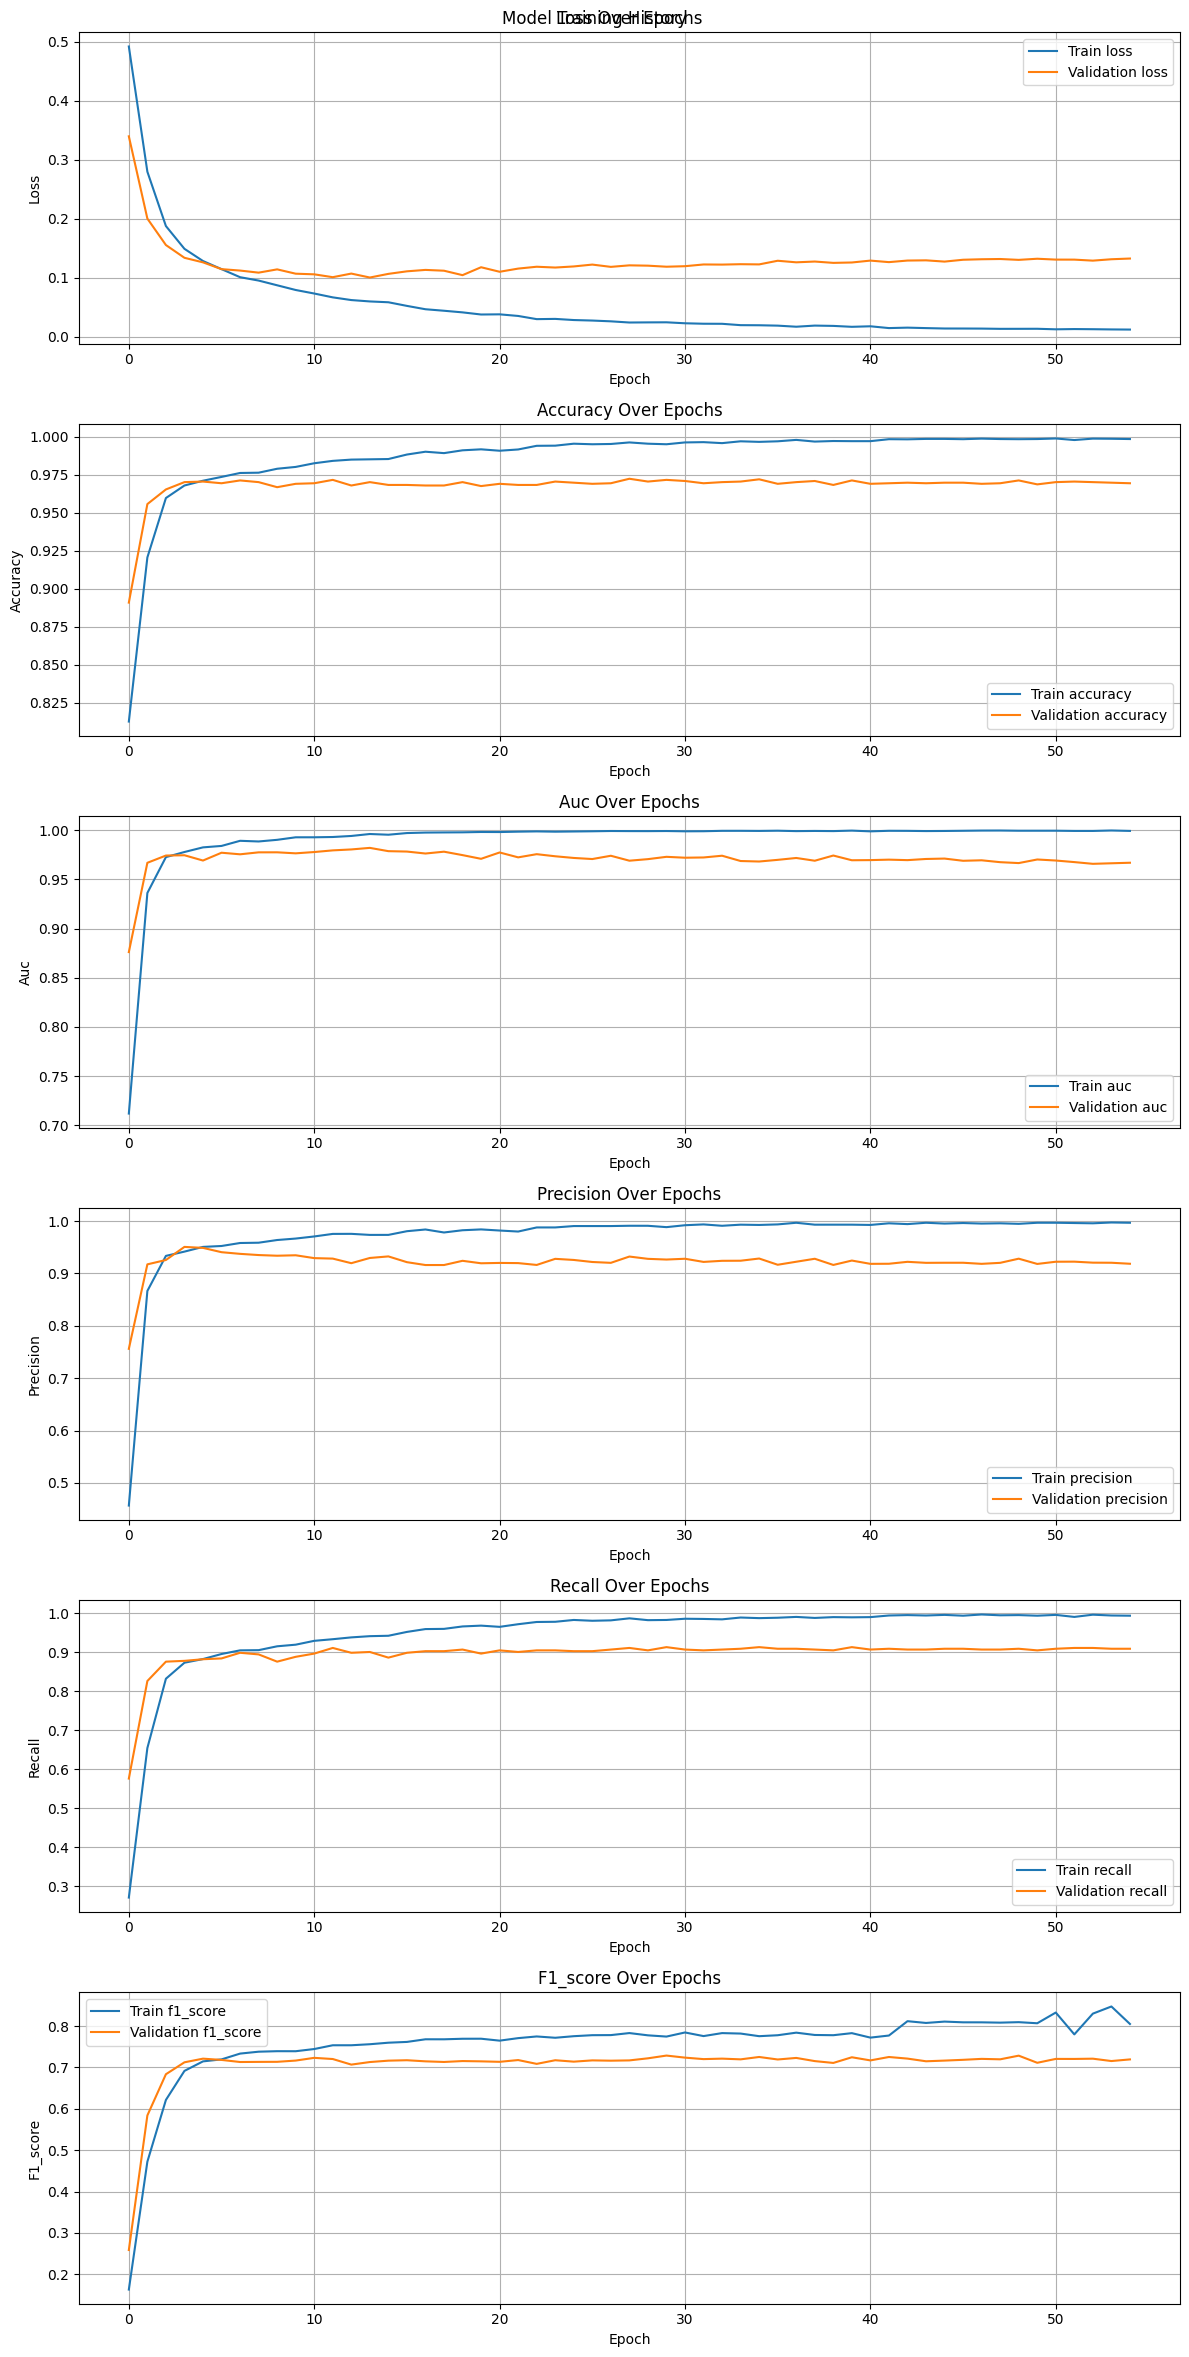

In [9]:
os.makedirs('./models', exist_ok=True)
os.makedirs('./weights', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

strategy = tf.distribute.OneDeviceStrategy("/gpu:0")

with strategy.scope():
    model = create_model()

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    acc = tf.keras.metrics.BinaryAccuracy('accuracy')
    auc = tf.keras.metrics.AUC(name='auc')
    precision = tf.keras.metrics.Precision(name='precision')
    recall = tf.keras.metrics.Recall(name='recall')
    f1_score = tf.keras.metrics.F1Score(average='macro', name='f1_score')

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[acc, auc, precision, recall, f1_score]
    )
    model.summary()

    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        './models/best_model.keras',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
    # Checkpoint for saving only the weights
    weights_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        './weights/best_model_weights.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_score',
        mode='max',
        patience=PATIENCE_CALLBACK,
        verbose=1,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.5,
        patience=LR_CALLBACK,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    
    history = model.fit(
        (train_input_ids, train_attention_masks),
        y_train,
        validation_data=((valid_input_ids,valid_attention_masks), y_valid),
        epochs=EPOCH,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint, weights_checkpoint, tensorboard_callback, early_stopping, reduce_lr]
    )
    plot_training_history(history)



In [10]:
job_titles = [
    "CIO Advisory Industry Consulting Director",
    "Senior Vice President, Global Information Technology",
    "VP Information Systems and Technology",
    "Erp Analyst",
    "Infrastructure Specialist",
    "Senior Vice President Marketing & Cummunications",
    "Senior Chief IT Quality Specialist",
    "Head of IT Security Controls and Integration",
    "Vice President - Systems & Software",
    "Senior Principal Development Engineer Enterprise and Data Center Infrastructure",
    "VP of Customs and Trade Business Development",
    "Vice President Trade Marketing and Demand Planning Business Unit General Manager",
    "Senior Geotechnical Engineer, Risk Specialist",
    "Network Operations Engineer",
    "Chief of Strategy and Innovation",
    "Information Technology Support Engineer",
    "Quality Assurance Engineer II",
    "Evp Operations",
    "Systems Engineer Secuirty",
    "VP, Corporate Controller",
    "Application Development Engineer",
    "Systems Engineer I",
    "Lead DevOps/Deployment Automation Cloud Engineer",
    "Vice President, Production Finance Television",
    "Software Engineer III, Backend",
    "Survey Systems Development Engineer III",
    "EA CEO David Ellison",
    "Field Application / Product Development Engineer",
    "Vice President General Manager, Hecla Limited",
    "Sr. Vice President, PE,LEED AP",
    "Systems Administrator, ILS",
    "Sys Admin Unix/Linux",
    "Systems Network Administrator",
    "Cloud Network Engineer",
    "Database Engineer",
    "NOC Administrator",
    "Assistant Manager Quality Control",
    "Senior Principal",
    "Mobile Operations Supervisor",
    "Emerging Markets | Business Development | Senior Vice President",
    "Senior Vice President, Products",
    "Web Application Developer",
    "Email & Front End Web Developer II",
    "Web Engineer",
    "Front End Developer",
    "Vice President, Technology Operations and Information Security",
    "iOS Developer",
    "Tableau Developer",
    "Vice President & CIO",
    "Vice President of Technology & CIO",
    "VP Data Science and Technology",
    "Corporate IT Director & CISO",
    "Haskell Developer"
]
dataset_predict = JobDataset()
for title in job_titles:
    x = dataset_predict.preprocess_title(title)
    x = dataset_predict.tokenize(x)
    x = model.predict(x)[0]
    print(f"{title}: {dataset_predict.predict_labels(x)}\n")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1/1 [==============================] - 11s 11s/step
CIO Advisory Industry Consulting Director: ['Chief Officer']

1/1 [==============================] - 0s 92ms/step
Senior Vice President, Global Information Technology: ['Vice President']

1/1 [==============================] - 0s 92ms/step
VP Information Systems and Technology: ['Vice President']

1/1 [==============================] - 0s 95ms/step
Erp Analyst: ['Individual Contributor/Staff']

1/1 [==============================] - 0s 93ms/step
Infrastructure Specialist: ['Individual Contributor/Staff']

1/1 [==============================] - 0s 91ms/step
Senior Vice President Marketing & Cummunications: ['Vice President']

1/1 [==============================] - 0s 92ms/step
Senior Chief IT Quality Specialist: ['Individual Contributor/Staff']

1/1 [==============================] - 0s 98ms/step
Head of IT Security Controls and Integration: ['Vice President']

1/1 [==============================] - 0s 94ms/step
Vice President - System